# Reconhecimento de Padrões - trabalho computacional

### Importando dados

In [174]:
import numpy as np
import pandas as pd

# função para divisão dos dados em treino e teste
from sklearn.model_selection import train_test_split

Clinical Attributes: (take values 0, 1, 2, 3, unless otherwise indicated)
Histopathological Attributes: (take values 0, 1, 2, 3)

* 1: erythema
* 2: scaling
* 3: definite borders
* 4: itching
* 5: koebner phenomenon
* 6: polygonal papules
* 7: follicular papules
* 8: oral mucosal involvement
* 9: knee and elbow involvement
* 10: scalp involvement
* 11: family history, (0 or 1)
* 34: Age (linear)


* 12: melanin incontinence
* 13: eosinophils in the infiltrate
* 14: PNL infiltrate
* 15: fibrosis of the papillary dermis
* 16: exocytosis
* 17: acanthosis
* 18: hyperkeratosis
* 19: parakeratosis
* 20: clubbing of the rete ridges
* 21: elongation of the rete ridges
* 22: thinning of the suprapapillary epidermis
* 23: spongiform pustule
* 24: munro microabcess
* 25: focal hypergranulosis
* 26: disappearance of the granular layer
* 27: vacuolisation and damage of basal layer
* 28: spongiosis
* 29: saw-tooth appearance of retes
* 30: follicular horn plug
* 31: perifollicular parakeratosis
* 32: inflammatory monoluclear inflitrate
* 33: band-like infiltrate

In [41]:
df = pd.read_csv('dados/dermatology.data', header=None)

In [42]:
# substituindo valores nulos da coluna de idade e transforomando para inteiro
df[33] = df[33].apply(lambda x: '0' if x == '?' else x).astype('int')

## 1. kNN para cada uma das seguintes distâncias: quarteirão e euclidiana

In [311]:
# importando função para calcular distâncias
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.preprocessing import StandardScaler

In [312]:
# função para cálculo das distâncias
def get_distances(X_train, x, distance = 'euclidean'):
    if distance == 'euclidean':
        dists = pd.Series(euclidean_distances(X_train, [x]).reshape(len(X_train), ), index=X_train.index)
    else:
        dists = pd.Series(manhattan_distances(X_train, [x]).reshape(len(X_train), ), index=X_train.index)
    return dists

# retorna k vizinhos mais próximos a um determinado dado
def get_neighbors(X_train, k, x, y, distance = 'euclidean'):
    distances = get_distances(X_train, x, distance)
    neighbors_index = distances.sort_values()[:k].index
    return X_train.loc[neighbors_index]

def get_knn_prediction(X_train, y_train, k, x, y, distance = 'euclidean'):
    '''
        Classifies some point x based on the k nearest points
        
        params:
            df: pandas.DataFrame, the data to get the features and neighbors from
            k: int, number of neighbors
            x: pd.Series, a row from df to be classified
            y: the target column from df
            distance: str, defines if the distance used in the algorith is euclidean or manhattan. 
                Default: 'euclidean'
        
        returns: int, calculated class for x
    '''
    neighbors_index = get_neighbors(X_train, k, x, y, distance = distance).index
    neighbors_values = y_train.loc[neighbors_index]
    prediction = neighbors_values.value_counts().index[0]
    return prediction

def knn_predict(X_train, y_train, X_test, k, y, distance = 'euclidean'):
    preds = []
    for x in X_test.values:
        preds.append(get_knn_prediction(X_train, y_train, k, x, y, distance=distance))
    return np.array(preds)

## Treino e teste do knn - distância euclidiana

In [315]:
y_col = 10 # defining target column

X_train, X_test, y_train, y_test = train_test_split(df.drop(y_col, axis=1), df[y_col], 
                                  test_size = 0.2, random_state = 42)

In [316]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [317]:
# cross-validation to find optimal k based on the f1 score
f1 = []
for k in range(1, 21):
    knn_pred = knn_predict(X_train, y_train, X_test, k, y_col)
    f1.append(f1_score(y_test, knn_pred))

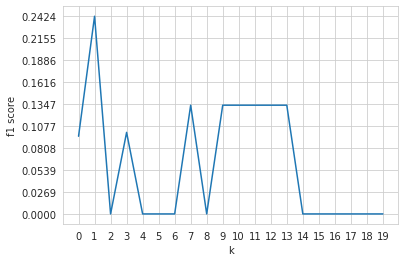

In [318]:
plt.plot(f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.xticks(np.arange(20))
plt.yticks(np.linspace(0, max(f1), 10));

In [319]:
y_pred_knn = knn_predict(X_train, y_train, X_test, 1, y_col)

In [320]:
k = 7
print('{}-NN Classifier Confusion Matrix:'.format(str(k)))

conf_matrix = pd.crosstab(y_test, y_pred_knn, rownames=['Actual'], 
                               colnames=['Predicted'], margins = False)
conf_matrix

7-NN Classifier Confusion Matrix:


Predicted,0,1
Actual,,
0,54,8
1,11,1


## Treino e teste do knn - distância manhattan

In [328]:
y_col = 10 # defining target column

X_train, X_test, y_train, y_test = train_test_split(df.drop(y_col, axis=1), df[y_col], 
                                  test_size = 0.2, random_state = 42)

In [329]:
# cross-validation to find optimal k based on the f1 score
f1 = []
for k in range(1, 21):
    knn_pred = knn_predict(X_train, y_train, X_test, k, y_col, distance='manhattan')
    f1.append(f1_score(y_test, knn_pred))

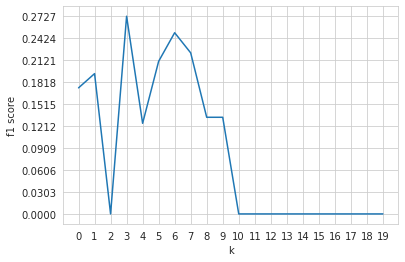

In [330]:
plt.plot(f1)
plt.xlabel('k')
plt.ylabel('f1 score')
plt.xticks(np.arange(20))
plt.yticks(np.linspace(0, max(f1), 10));

In [331]:
y_pred_knn = knn_predict(X_train, y_train, X_test, 3, y_col, distance='manhattan')

In [332]:
k = 7
print('{}-NN Classifier Confusion Matrix:'.format(str(k)))

conf_matrix = pd.crosstab(y_test, y_pred_knn, rownames=['Actual'], 
                               colnames=['Predicted'], margins = False)
conf_matrix

7-NN Classifier Confusion Matrix:


Predicted,0,1
Actual,,
0,58,4
1,12,0


## 2. Classificador gaussiano linear

In [321]:
# função para cálculo da gaussiana multivariada
from scipy.stats import multivariate_normal

In [322]:
class LinearGaussianClassifier:
    
    def fit(self, X_train, y_train):

        # get the data mean value for each class
        self.mean_0 = np.mean(X_train[y_train == 0])
        self.mean_1 = np.mean(X_train[y_train == 1])

        # get covariance (sigma parameter in gaussian distribution) for each class
        self.sigma_0 = np.cov(X_train[y_train == 0], rowvar = False)
        self.sigma_1 = np.cov(X_train[y_train == 1], rowvar = False)

        # get class percentage
        self.p_0 = len(y_train[y_train == 0])/len(y_train)
        self.p_1 = len(y_train[y_train == 1])/len(y_train)

        # get multivariate guassian probability for each class
        self.g_prob_0 = multivariate_normal(self.mean_0, self.sigma_0, allow_singular = True)
        self.g_prob_1 = multivariate_normal(self.mean_1, self.sigma_1, allow_singular = True)
        
    def predict(self, X_test):
        y_pred = []
        
        for x in X_test.values:
            # prediction based on the higher probability distribution function (pdf) for each class
            if self.g_prob_0.pdf(x)*self.p_0 > self.g_prob_1.pdf(x)*self.p_1:
                y_pred.append(0)
            else:
                y_pred.append(1)
                
        return np.array(y_pred)

### Treino e teste do classificador gaussiano linear

In [323]:
y_col = 10 # defining target column as the column 10

X_train, X_test, y_train, y_test = train_test_split(df.drop(y_col, axis=1), df[y_col],
                                                    test_size = 0.2, random_state = 42)

In [324]:
lgc = LinearGaussianClassifier()

In [325]:
lgc.fit(X_train, y_train)

In [326]:
y_pred = lgc.predict(X_test)

In [327]:
print('Linear Gaussian Classifier Confusion Matrix:')

conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'], margins = False)
conf_matrix

Linear Gaussian Classifier Confusion Matrix:


Predicted,0,1
Actual,,
0,59,3
1,11,1
